In [59]:
import os
import sys
import time
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

utils_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src/utils'
if not utils_dir in sys.path: sys.path.append(utils_dir)
from constants import *
from CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from matplotlib.ticker import FormatStrFormatter

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'

# Grab veldisp offsets
totoff = pd.read_csv(os.path.join(ROOT_PATH, 'artifacts/veldisp_calibration/totoffs.csv'))
off_6df = totoff.loc[0, ['off_6df']].values[0]
off_sdss = totoff.loc[0, ['off_sdss']].values[0]
off_lamost = totoff.loc[0, ['off_lamost']].values[0]

# Define the veldisp lower limit (as defined in the guide)
SURVEY_VELDISP_LIMIT = {
    # Default: use nominal veldisp limit + offset of each survey
    0: {
        '6dFGS': np.log10(112) - off_6df,
        'SDSS': np.log10(70) - off_sdss,
        'LAMOST': np.log10(50) - off_lamost
    },
    # First setting: use 6dFGS veldisp + offset for everything
    1: {
        '6dFGS': np.log10(112) - off_6df,
        'SDSS': np.log10(112) - off_6df,
        'LAMOST': np.log10(50) - off_lamost
    },
    # Second setting: use 6dFGS veldisp + offset for 6dFGS and SDSS and LAMOST veldisp + offset for LAMOST
    2: {
        '6dFGS': np.log10(112) - off_6df,
        'SDSS': np.log10(112) - off_6df,
        'LAMOST': np.log10(50) - off_lamost
    }
}

ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'

# 1. Fit the log-distance ratios

In [78]:
SMIN_SETTING = 1

OUTLIER_REJECT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'data/foundation/fp_sample/outlier_reject/smin_setting_{SMIN_SETTING}/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, f'data/foundation/fp_sample/outlier_reject/smin_setting_{SMIN_SETTING}/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, f'data/foundation/fp_sample/outlier_reject/smin_setting_{SMIN_SETTING}/lamost.csv')
}

FP_FIT_FILEPATH = os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fits.csv')

LOGDIST_POSTERIOR_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/lamost.csv')
}
create_parent_folder(LOGDIST_POSTERIOR_OUTPUT_FILEPATH)

# Sample selection constants
# The magnitude limit and velocity dispersion limits (very important!), and Omega_m (less important)
omega_m = 0.3121
mag_low = 8.0
mag_high = 13.65
zmin = 3000.0 / LIGHTSPEED
zmax = 16120. / LIGHTSPEED

def gaus(x, mu, sig):
    return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-0.5 * ((x - mu) / sig)**2)

def skewnormal(x, loc, err, alpha):
    A = 1 / (np.sqrt(2 * np.pi) * err)
    B = np.exp(-(x - loc)**2/(2 * err**2))
    C = 1 + erf(alpha * (x - loc) / (np.sqrt(2) * err))
    return A * B * C

for survey in SURVEY_LIST[2:3]:
    # Survey's veldisp limit
    smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

    # Get some redshift-distance lookup tables
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()

    df = pd.read_csv(OUTLIER_REJECT_FILEPATH[survey])
    dz = sp.interpolate.splev(df["z_cmb"].to_numpy()/LightSpeed, dist_spline)
    dz_cluster = sp.interpolate.splev(df["z_dist_est"], dist_spline)
    FPparams = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc[survey].to_numpy()
    print(f'Number of {survey} data = {len(df)}. FP best fits = {FPparams}')

    # Fit the logdistance ratios
    dmin, dmax, nd = -1.5, 1.5, 1001
    dbins = np.linspace(dmin, dmax, nd, endpoint=True)

    d_H = np.outer(10.0**(-dbins), dz_cluster)
    z_H = sp.interpolate.splev(d_H, red_spline, der=0)
    lmin = (SOLAR_MAGNITUDE['j'] + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_j"].to_numpy() + df["extinction_j"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_high) / 5.0
    lmax = (SOLAR_MAGNITUDE['j'] + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_j"].to_numpy() + df["extinction_j"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_low) / 5.0
    loglike = FP_func(FPparams, dbins, df["z_cmb"].to_numpy(), df["r"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), np.ones(len(df)), smin, sumgals=False)
    start = time.time()
    FNvals = FN_func(FPparams, df["z_cmb"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), lmin, lmax, smin)
    print(f'Time elapsed = {time.time() - start} s.')

    # Convert to the PDF for logdistance
    logP_dist = -1.5 * np.log(2.0 * math.pi) - loglike - FNvals

    # normalise logP_dist
    ddiff = np.log10(d_H[:-1]) - np.log10(d_H[1:])
    valdiff = np.exp(logP_dist[1:]) + np.exp(logP_dist[0:-1])
    norm_ = 0.5 * np.sum(valdiff * ddiff, axis=0)

    logP_dist -= np.log(norm_[:, None]).T

    # Calculate the mean and variance of the gaussian, then the skew
    mean = np.sum(dbins[0:-1,None]*np.exp(logP_dist[0:-1])+dbins[1:,None]*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0
    err = np.sqrt(np.sum(dbins[0:-1,None]**2*np.exp(logP_dist[0:-1])+dbins[1:,None]**2*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - mean**2)
    gamma1 = (np.sum(dbins[0:-1,None]**3*np.exp(logP_dist[0:-1])+dbins[1:,None]**3*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - 3.0*mean*err**2 - mean**3)/err**3
    gamma1 = np.where(gamma1 > 0.99, 0.99, gamma1)
    gamma1 = np.where(gamma1 < -0.99, -0.99, gamma1)
    delta = np.sign(gamma1)*np.sqrt(np.pi/2.0*1.0/(1.0 + ((4.0 - np.pi)/(2.0*np.abs(gamma1)))**(2.0/3.0)))
    scale = err*np.sqrt(1.0/(1.0 - 2.0*delta**2/np.pi))
    loc = mean - scale*delta*np.sqrt(2.0/np.pi)
    alpha = delta/(np.sqrt(1.0 - delta**2))

    # Store the skew-normal values to the dataframe
    df["logdist_mean"] = mean
    df["logdist_std"] = err
    df["logdist_alpha"] = alpha
    df["logdist_loc"] = loc
    df["logdist_scale"] = scale
    
    # Transpose the PDF and return to linear unit
    y = np.exp(logP_dist.T)
    # Save the posterior distribution
#     np.save('../artifacts/logdist/', y)

    # Find mean and standard deviation of the distribution using curve_fit
    logdist_mean = []
    logdist_std = []
    chisq = []

    for i, y_ in enumerate(y):
        popt, pcov = curve_fit(gaus, dbins, y_, p0=[mean[i], err[i]])
        popt[1] = np.absolute(popt[1])
        logdist_mean.append(popt[0])
        logdist_std.append(popt[1])
        
        # Calculate the chi-squared statistic for the fit
        ypred = norm.pdf(dbins, popt[0], popt[1])
        chisquare = np.sum((y_ - ypred)**2 / ypred, axis=0)
        chisq.append(chisquare)

    df['logdist_mean_cf'] = logdist_mean
    df['logdist_std_cf'] = logdist_std
    df['logdist_chisq_cf'] = chisq

Number of LAMOST data = 2111. FP best fits = [ 1.59005948 -0.82413448 -0.10179209  2.18741952  3.4471426   0.06154192
  0.29798322  0.17612234]
Time elapsed = 1.2806599140167236 s.


# 2. Analyze the posterior distribution

## 2.1. Compare analytical results vs curve_fit

### 2.1.1. 6dFGS

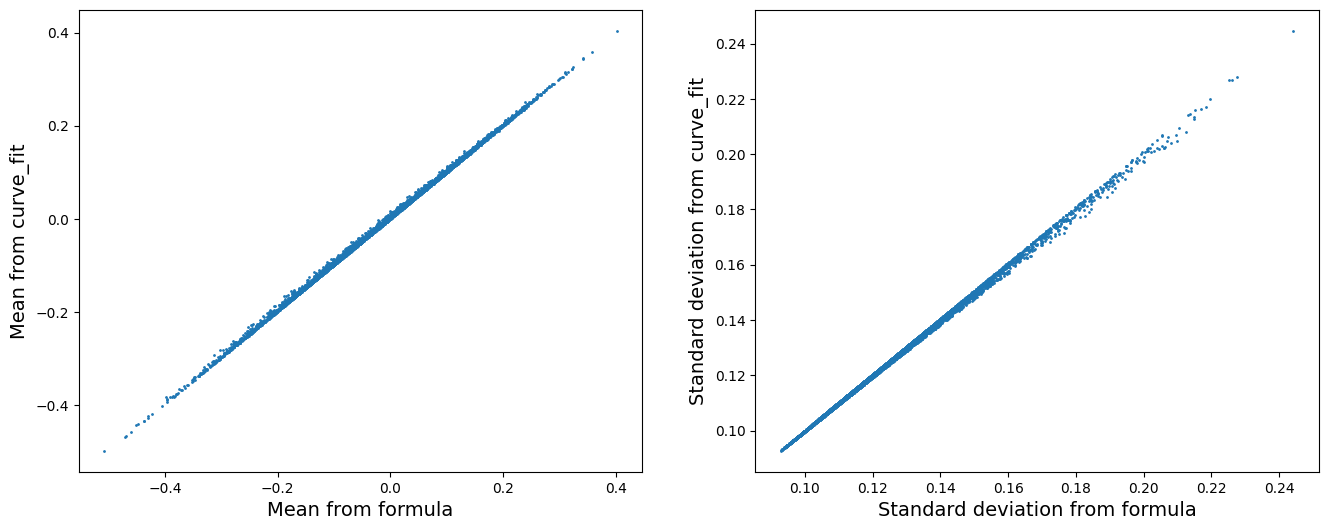

In [89]:
# Load dataframe with logdist
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/6dfgs.csv')

# Compare Cullan's mean and curve_fit mean
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.scatter(df['logdist_mean'], df['logdist_mean_cf'], s=1)
ax1.set_ylabel('Mean from curve_fit', size=14)
ax1.set_xlabel('Mean from formula', size=14)

# Compare Cullan's std and curve_fit std
ax2.scatter(df['logdist_std'], df['logdist_std_cf'], s=1)
ax2.set_ylabel('Standard deviation from curve_fit', size=14)
ax2.set_xlabel('Standard deviation from formula', size=14)

plt.show()

### 2.1.2. SDSS

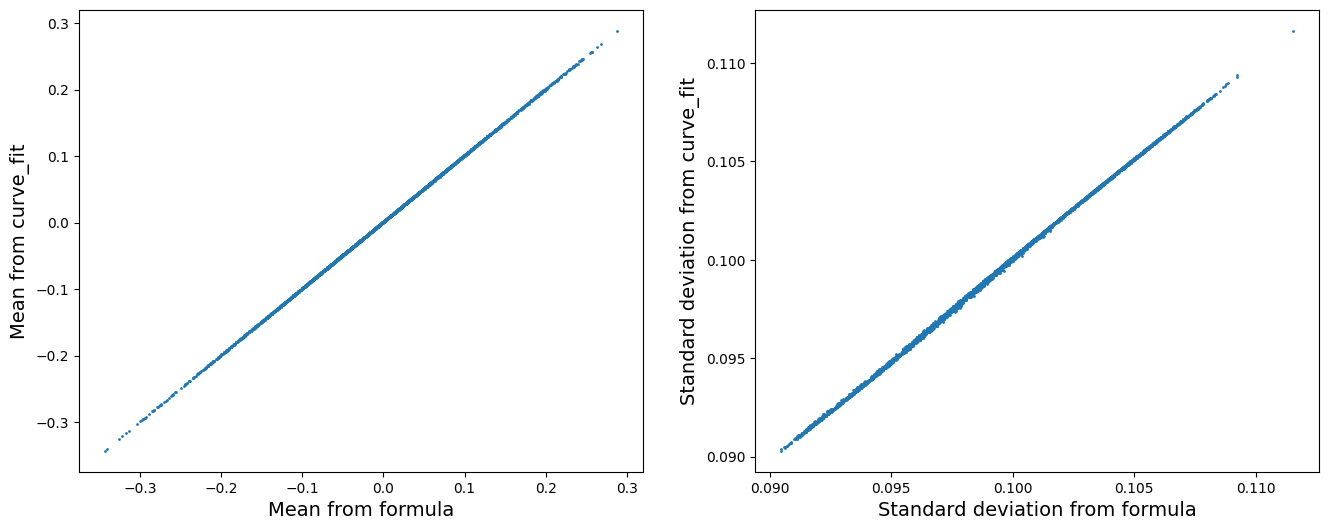

In [90]:
# Load dataframe with logdist
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/sdss.csv')

# Compare Cullan's mean and curve_fit mean
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.scatter(df['logdist_mean'], df['logdist_mean_cf'], s=1)
ax1.set_ylabel('Mean from curve_fit', size=14)
ax1.set_xlabel('Mean from formula', size=14)

# Compare Cullan's std and curve_fit std
ax2.scatter(df['logdist_std'], df['logdist_std_cf'], s=1)
ax2.set_ylabel('Standard deviation from curve_fit', size=14)
ax2.set_xlabel('Standard deviation from formula', size=14)

plt.show()

### 2.1.3. LAMOST

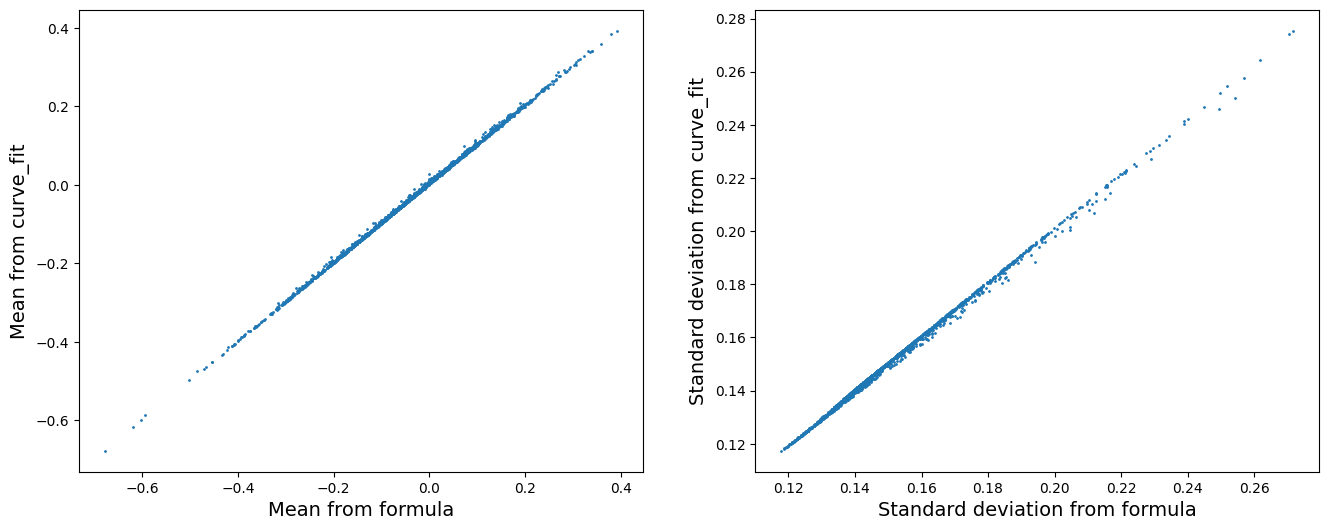

In [93]:
# Load dataframe with logdist
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/lamost.csv')

# Compare Cullan's mean and curve_fit mean
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.scatter(df['logdist_mean'], df['logdist_mean_cf'], s=1)
ax1.set_ylabel('Mean from curve_fit', size=14)
ax1.set_xlabel('Mean from formula', size=14)

# Compare Cullan's std and curve_fit std
ax2.scatter(df['logdist_std'], df['logdist_std_cf'], s=1)
ax2.set_ylabel('Standard deviation from curve_fit', size=14)
ax2.set_xlabel('Standard deviation from formula', size=14)

plt.show()

### 2.1.4. Production code

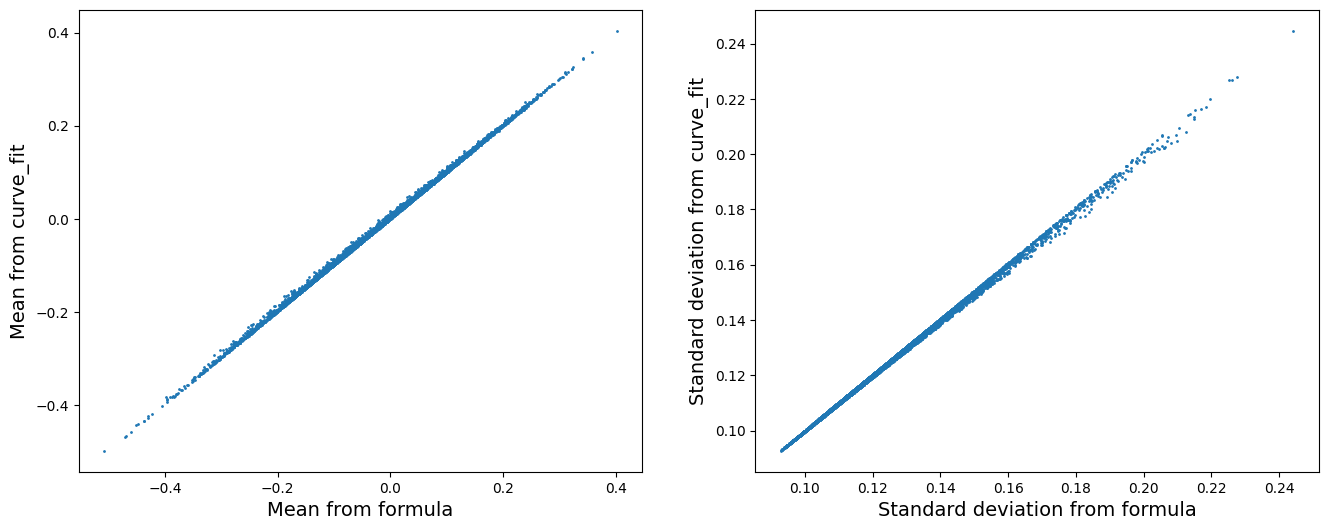

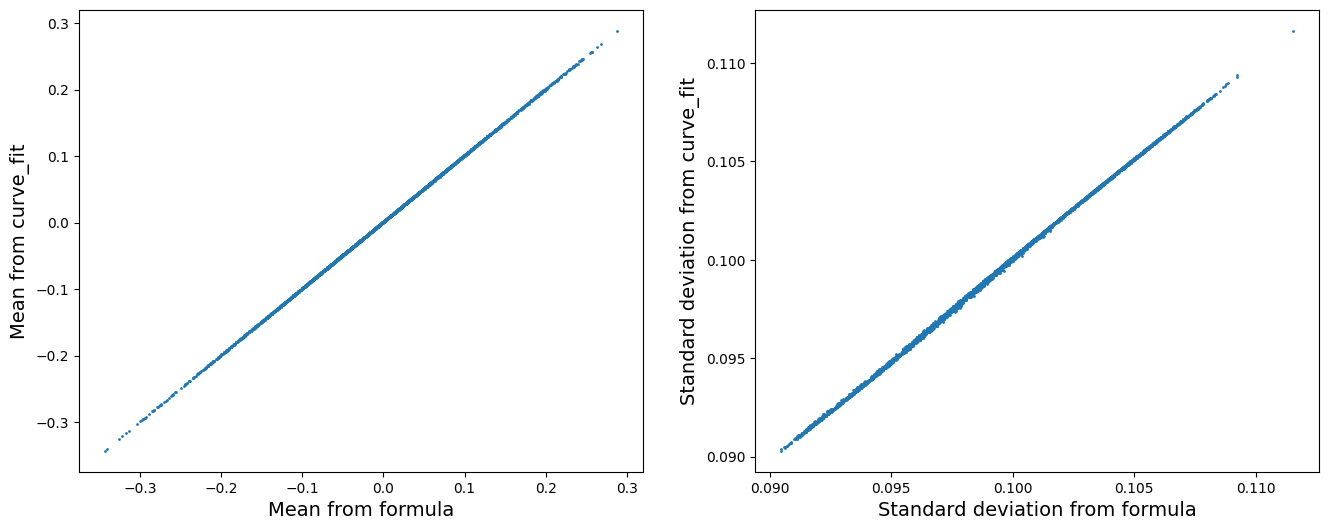

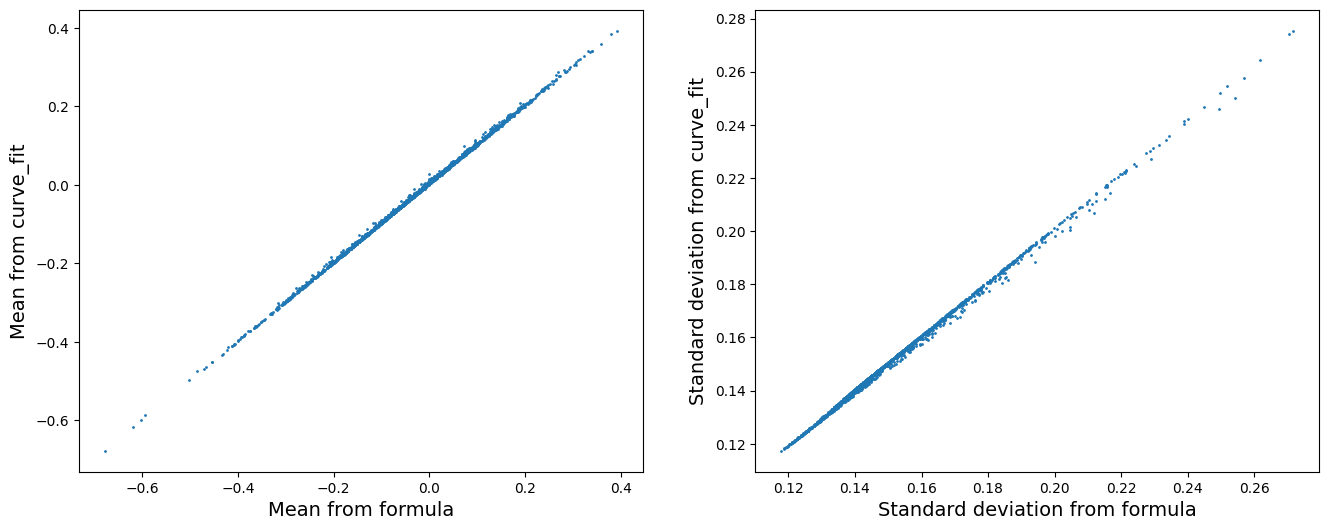

In [94]:
LOGDIST_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'data/foundation/logdist/smin_setting_{SMIN_SETTING}/6dfgs.csv'),
    'SDSS': os.path.join(ROOT_PATH, f'data/foundation/logdist/smin_setting_{SMIN_SETTING}/sdss.csv'),
    'LAMOST': os.path.join(ROOT_PATH, f'data/foundation/logdist/smin_setting_{SMIN_SETTING}/lamost.csv')
}

CURVEFIT_COMPARISON_IMG_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'img/logdist/smin_setting_{SMIN_SETTING}/6dfgs.png'),
    'SDSS': os.path.join(ROOT_PATH, f'img/logdist/smin_setting_{SMIN_SETTING}/sdss.png'),
    'LAMOST': os.path.join(ROOT_PATH, f'img/logdist/smin_setting_{SMIN_SETTING}/lamost.png')
}

def compare_cf_vs_formula():
    for survey in SURVEY_LIST:
        df = pd.read_csv(LOGDIST_OUTPUT_FILEPATH[survey])
        
        # Compare Cullan's mean and curve_fit mean
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
        ax1.scatter(df['logdist_mean'], df['logdist_mean_cf'], s=1)
        ax1.set_ylabel('Mean from curve_fit', size=14)
        ax1.set_xlabel('Mean from formula', size=14)

        # Compare Cullan's std and curve_fit std
        ax2.scatter(df['logdist_std'], df['logdist_std_cf'], s=1)
        ax2.set_ylabel('Standard deviation from curve_fit', size=14)
        ax2.set_xlabel('Standard deviation from formula', size=14)

        plt.savefig(CURVEFIT_COMPARISON_IMG_FILEPATH[survey], dpi=300)
        
compare_cf_vs_formula()

## 2.2. Inspect the most skewed posterior distribution

### 2.2.1. 6dFGS

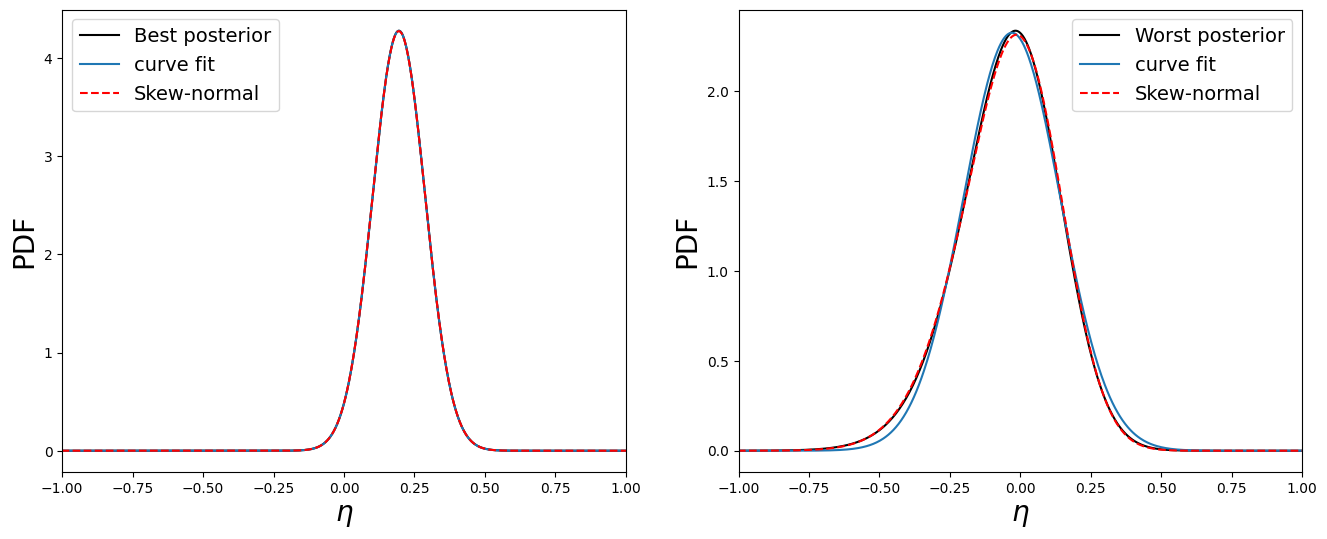

In [106]:
# Load the posterior distributions
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/6dfgs.csv')
dbins = np.linspace(-1.5, 1.5, 1001, endpoint=True)
y = np.load('../artifacts/logdist/smin_setting_1/6dfgs_logdist_posterior.npy')

# Grab the index with the best and worst chi-square (relative to a Gaussian distribution)
index_worst = df['logdist_chisq_cf'].sort_values().index[-1]
index_best = df['logdist_chisq_cf'].sort_values().index[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the best posteriors
ax1.plot(dbins, y[index_best, :], label='Best posterior', color='k')
ax1.plot(dbins, norm.pdf(dbins, loc=df.loc[index_best, 'logdist_mean_cf'], scale=df.loc[index_best, 'logdist_std_cf']), label='curve fit')
ax1.plot(dbins, skewnormal(dbins, loc=df.loc[index_best, 'logdist_loc'], err=df.loc[index_best, 'logdist_scale'], alpha=df.loc[index_best, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
ax1.set_xlim(-1.0, 1.0)
ax1.set_xlabel(r'$\eta$', size=20)
ax1.set_ylabel(r'PDF', size=20)
ax1.legend(fontsize=14)

# Plot the worst posterior
ax2.plot(dbins, y[index_worst, :], label='Worst posterior', color='k')
ax2.plot(dbins, norm.pdf(dbins, loc=df.loc[index_worst, 'logdist_mean_cf'], scale=df.loc[index_worst, 'logdist_std_cf']), label='curve fit')
ax2.plot(dbins, skewnormal(dbins, loc=df.loc[index_worst, 'logdist_loc'], err=df.loc[index_worst, 'logdist_scale'], alpha=df.loc[index_worst, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
ax2.set_xlim(-1.0, 1.0)
ax2.set_xlabel(r'$\eta$', size=20)
ax2.set_ylabel(r'PDF', size=20)
ax2.legend(fontsize=14)

plt.show()

### 2.2.2. SDSS

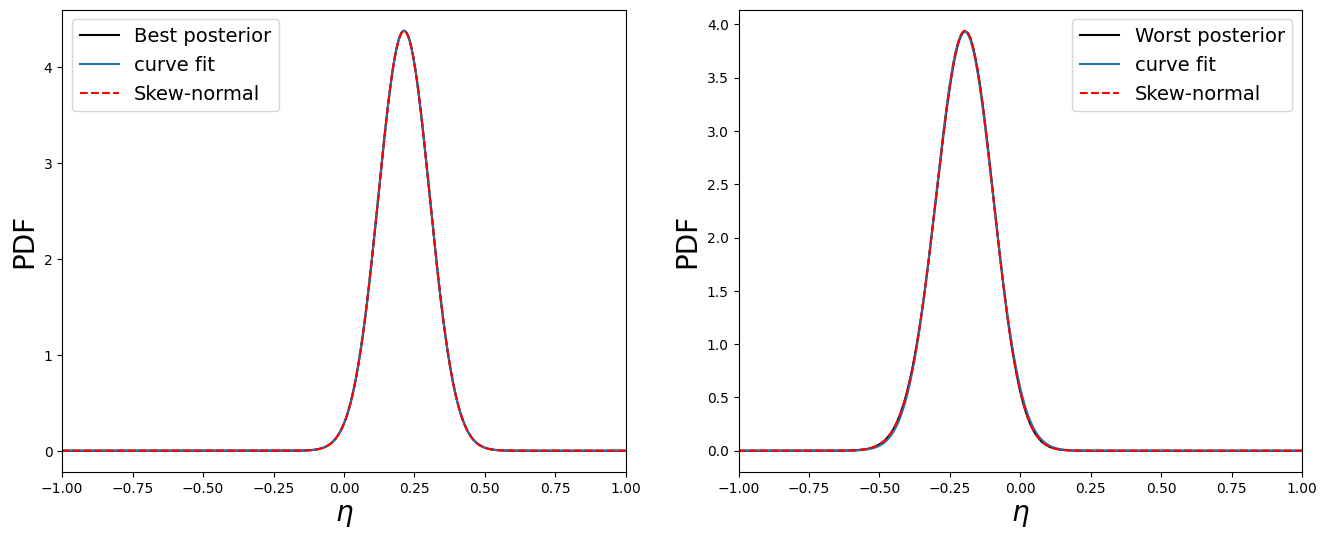

In [107]:
# Load the posterior distributions
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/sdss.csv')
dbins = np.linspace(-1.5, 1.5, 1001, endpoint=True)
y = np.load('../artifacts/logdist/smin_setting_1/sdss_logdist_posterior.npy')

# Grab the index with the best and worst chi-square (relative to a Gaussian distribution)
index_worst = df['logdist_chisq_cf'].sort_values().index[-1]
index_best = df['logdist_chisq_cf'].sort_values().index[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the best posteriors
ax1.plot(dbins, y[index_best, :], label='Best posterior', color='k')
ax1.plot(dbins, norm.pdf(dbins, loc=df.loc[index_best, 'logdist_mean_cf'], scale=df.loc[index_best, 'logdist_std_cf']), label='curve fit')
ax1.plot(dbins, skewnormal(dbins, loc=df.loc[index_best, 'logdist_loc'], err=df.loc[index_best, 'logdist_scale'], alpha=df.loc[index_best, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
ax1.set_xlim(-1.0, 1.0)
ax1.set_xlabel(r'$\eta$', size=20)
ax1.set_ylabel(r'PDF', size=20)
ax1.legend(fontsize=14)

# Plot the worst posterior
ax2.plot(dbins, y[index_worst, :], label='Worst posterior', color='k')
ax2.plot(dbins, norm.pdf(dbins, loc=df.loc[index_worst, 'logdist_mean_cf'], scale=df.loc[index_worst, 'logdist_std_cf']), label='curve fit')
ax2.plot(dbins, skewnormal(dbins, loc=df.loc[index_worst, 'logdist_loc'], err=df.loc[index_worst, 'logdist_scale'], alpha=df.loc[index_worst, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
ax2.set_xlim(-1.0, 1.0)
ax2.set_xlabel(r'$\eta$', size=20)
ax2.set_ylabel(r'PDF', size=20)
ax2.legend(fontsize=14)

plt.show()

### 2.2.3. LAMOST

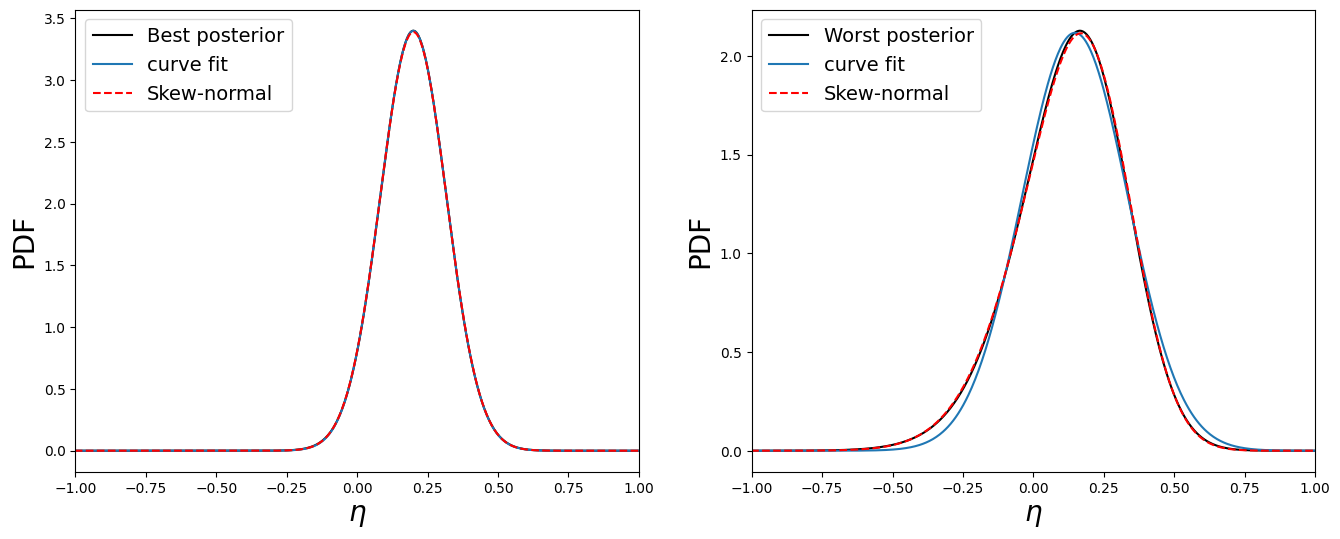

In [108]:
# Load the posterior distributions
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/lamost.csv')
dbins = np.linspace(-1.5, 1.5, 1001, endpoint=True)
y = np.load('../artifacts/logdist/smin_setting_1/lamost_logdist_posterior.npy')

# Grab the index with the best and worst chi-square (relative to a Gaussian distribution)
index_worst = df['logdist_chisq_cf'].sort_values().index[-1]
index_best = df['logdist_chisq_cf'].sort_values().index[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the best posteriors
ax1.plot(dbins, y[index_best, :], label='Best posterior', color='k')
ax1.plot(dbins, norm.pdf(dbins, loc=df.loc[index_best, 'logdist_mean_cf'], scale=df.loc[index_best, 'logdist_std_cf']), label='curve fit')
ax1.plot(dbins, skewnormal(dbins, loc=df.loc[index_best, 'logdist_loc'], err=df.loc[index_best, 'logdist_scale'], alpha=df.loc[index_best, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
ax1.set_xlim(-1.0, 1.0)
ax1.set_xlabel(r'$\eta$', size=20)
ax1.set_ylabel(r'PDF', size=20)
ax1.legend(fontsize=14)

# Plot the worst posterior
ax2.plot(dbins, y[index_worst, :], label='Worst posterior', color='k')
ax2.plot(dbins, norm.pdf(dbins, loc=df.loc[index_worst, 'logdist_mean_cf'], scale=df.loc[index_worst, 'logdist_std_cf']), label='curve fit')
ax2.plot(dbins, skewnormal(dbins, loc=df.loc[index_worst, 'logdist_loc'], err=df.loc[index_worst, 'logdist_scale'], alpha=df.loc[index_worst, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
ax2.set_xlim(-1.0, 1.0)
ax2.set_xlabel(r'$\eta$', size=20)
ax2.set_ylabel(r'PDF', size=20)
ax2.legend(fontsize=14)

plt.show()

### 2.2.4. Production code

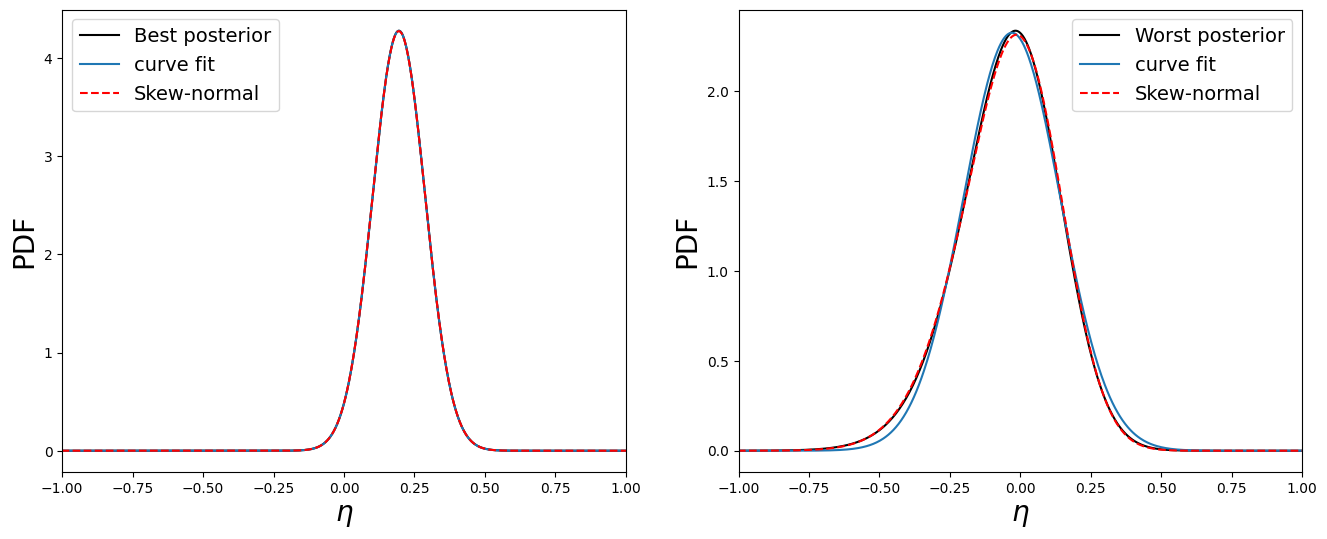

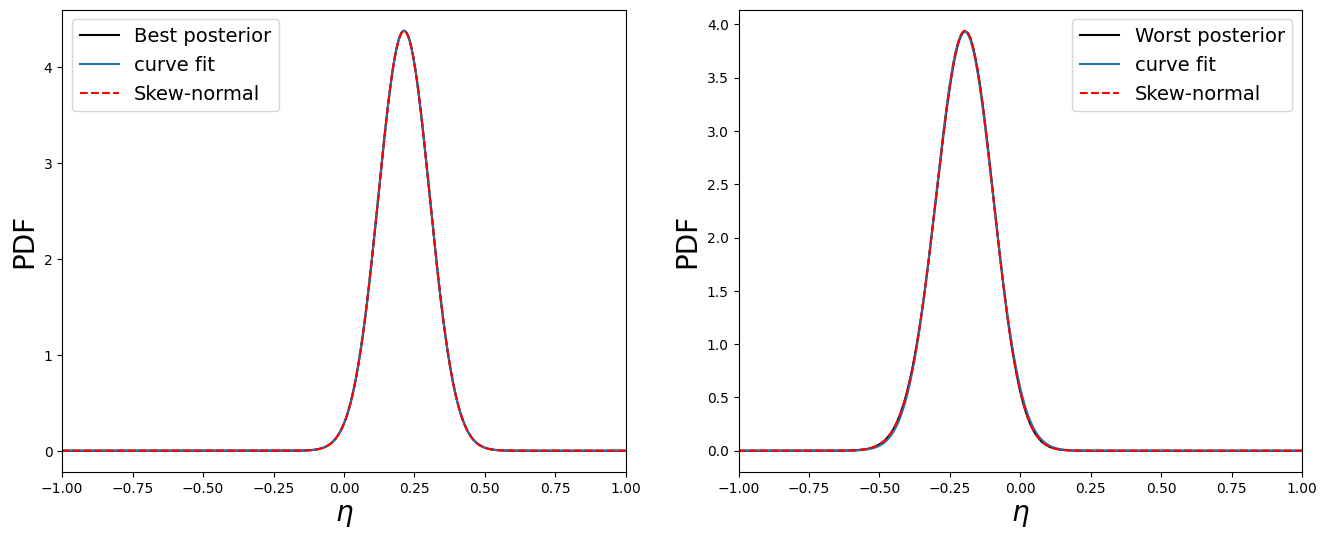

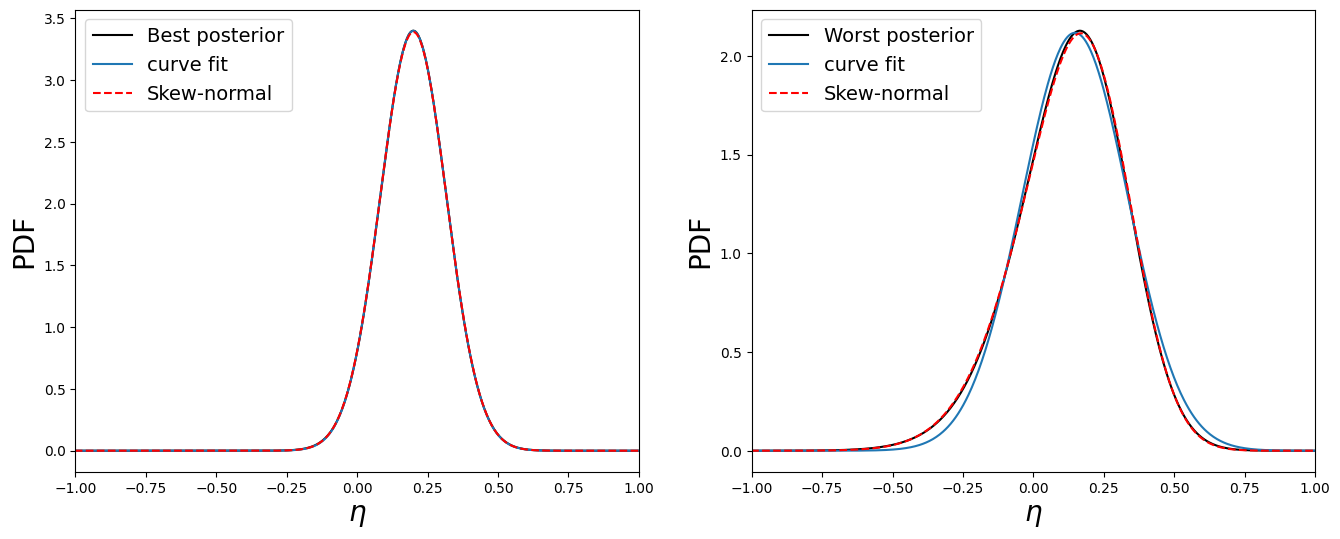

In [111]:
LOGDIST_POSTERIOR_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/6dfgs_logdist_posterior.npy'),
    'SDSS': os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/sdss_logdist_posterior.npy'),
    'LAMOST': os.path.join(ROOT_PATH, f'artifacts/logdist/smin_setting_{SMIN_SETTING}/lamost_logdist_posterior.npy')
}

POSTERIOR_SKEWNESS_IMG_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'img/logdist/smin_setting_{SMIN_SETTING}/6dfgs_best_worst.png'),
    'SDSS': os.path.join(ROOT_PATH, f'img/logdist/smin_setting_{SMIN_SETTING}/sdss_best_worst.png'),
    'LAMOST': os.path.join(ROOT_PATH, f'img/logdist/smin_setting_{SMIN_SETTING}/lamost_best_worst.png')
}

def plot_best_worst_posterior():
    for survey in SURVEY_LIST:
        # Load the posterior distributions
        df = pd.read_csv(LOGDIST_OUTPUT_FILEPATH[survey])
        dbins = np.linspace(-1.5, 1.5, 1001, endpoint=True)
        y = np.load(LOGDIST_POSTERIOR_OUTPUT_FILEPATH[survey])

        # Grab the index with the best and worst chi-square (relative to a Gaussian distribution)
        index_worst = df['logdist_chisq_cf'].sort_values().index[-1]
        index_best = df['logdist_chisq_cf'].sort_values().index[0]

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

        # Plot the best posteriors
        ax1.plot(dbins, y[index_best, :], label='Best posterior', color='k')
        ax1.plot(dbins, norm.pdf(dbins, loc=df.loc[index_best, 'logdist_mean_cf'], scale=df.loc[index_best, 'logdist_std_cf']), label='curve fit')
        ax1.plot(dbins, skewnormal(dbins, loc=df.loc[index_best, 'logdist_loc'], err=df.loc[index_best, 'logdist_scale'], alpha=df.loc[index_best, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
        ax1.set_xlim(-1.0, 1.0)
        ax1.set_xlabel(r'$\eta$', size=20)
        ax1.set_ylabel(r'PDF', size=20)
        ax1.legend(fontsize=14)

        # Plot the worst posterior
        ax2.plot(dbins, y[index_worst, :], label='Worst posterior', color='k')
        ax2.plot(dbins, norm.pdf(dbins, loc=df.loc[index_worst, 'logdist_mean_cf'], scale=df.loc[index_worst, 'logdist_std_cf']), label='curve fit')
        ax2.plot(dbins, skewnormal(dbins, loc=df.loc[index_worst, 'logdist_loc'], err=df.loc[index_worst, 'logdist_scale'], alpha=df.loc[index_worst, 'logdist_alpha']), c='red', ls='--', label='Skew-normal')
        ax2.set_xlim(-1.0, 1.0)
        ax2.set_xlabel(r'$\eta$', size=20)
        ax2.set_ylabel(r'PDF', size=20)
        ax2.legend(fontsize=14)

#         plt.savefig(CURVEFIT_COMPARISON_IMG_FILEPATH[survey], dpi=300)
plot_best_worst_posterior()

## 2.3. Univariate Analysis

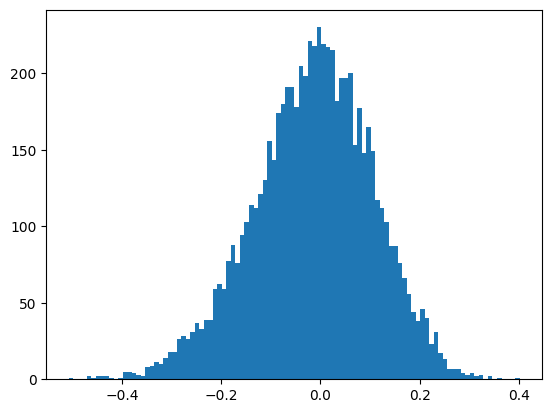

In [22]:
plt.hist(df['logdist'], bins=100)
plt.show()